# Homework 2 : 單光子電腦斷層掃描的多類別分類
在這份作業中，請各位將 TODO 填寫好。

1. 調整適當的參數。
2. 將 validation 空白處填起來讓程式能夠運作
3. 寫出當 mode = valid、test 的 getitem()。
4. split the training dataset。
5. 調整適當的 optimizer、scheduler，雖然不一定會比較好，但可以嘗試看看。
6. 畫出 train 跟 valid 的 Misclassification Rate 圖。
7. 用相似的手法建立 Resnet, VIT model 架構。
8. 在 testing 裡填空格。
9. 填寫 test_dataset、test_loader、model 三個空格。
10. 挑選你認為最好的 model 並將預測結果輸出在 submission.csv。

kaggle rule:
1. 不得使用兩隻以上的帳號繳交 submission檔案 (可參加但不可丟答案)
2. team的名稱記得一定要改成學號

## Import Packages

In [11]:
# torchsummary 可以讓模型視覺化，以及匯出模型每層的詳細數量和每層的比例。
# !pip install torchsummary

In [12]:
import pydicom
import pandas as pd
import numpy as np
import os
import random

import pydicom
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

2.4.1+cu118
11.8
90100
True


## Configuration

In [13]:
# TODO_1: 調整適當的參數(除了 num_classes，你可以任意調整以下的超參數)

class config:
    
    root = "./hwk02_data" #"/kaggle/input/2024dl"
    batch_size = 16
    lr = 1e-4
    epochs = 150
    weight_decay = 1e-3
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 3
    
print('device:', config.device)

device: cuda


## Input Data

In [14]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 161
Number of testing samples: 41


In [15]:
train_data['Stage'].value_counts().sort_index()

Stage
1    44
2    42
3    75
Name: count, dtype: int64

In [16]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    # 作用是啟用 batch normalization 和 dropout。
    # 保證 BN 層能夠用到每個 batch 資料的平均值和變異數。對於 Dropout 是隨機取一部分網路連線來訓練更新參數。
    model.train() 
    
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, ages, genders, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        ages = ages.to(device = device, dtype = torch.float)
        genders = genders.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        # Pytorch 中的分類損失函數（如 CrossEntropyLoss）期望 label 為 0 開始的整數。
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        scheduler.step() #switch place

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)
    # scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass


def validation(model, valid_loader, criterion, device):
    # 確保 BN 層能夠用全部訓練資料的平均值和變異數，即驗證過程中要保證 BN 層的平均值和變異數不變。對於 Dropout 是利用了所有網路連接，即不進行隨機捨棄神經元。
    # pytorch 會自動把 BN 和 DropOut 固定住，不會取平均，而是用訓練好的數值。
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    # TODO_2: 請將空白處填起來讓程式能夠運作。

    # 這邊禁用 PyTorch 梯度的自動計算，因為在 validation 階段我們不需要更新 model 的權重，因此不需要進行反向傳播(backpropagation)和梯度計算。
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            # Move data to the device (GPU or CPU)
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            # Forward pass: compute logits
            logits = model(images, ages, genders)
            
            # Adjust labels: converting from [1,2,3] to [0,1,2] as expected by CrossEntropyLoss
            labels = torch.sub(labels, 1)
            
            # Compute loss
            loss = criterion(logits, labels)

            # Accumulate validation loss
            valid_loss += loss.item()

            # Get predictions: select the index with the highest logit
            preds = torch.argmax(logits, dim=1)

            # Append predictions and ground truths for evaluation
            predictions.append(preds)
            ground_truths.append(labels)

        # Average validation loss over the entire dataset
        valid_loss /= len(valid_loader)

        # Concatenate all predictions and ground truths from different batches
        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)

        # Calculate validation accuracy, F1 score, and misclassification rate
        valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
        
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass


def printTrainresult(history, eps):
    train_loss=history["train"]["loss"][eps]
    train_acc=history["train"]["acc"][eps]
    train_f1=history["train"]["f1"][eps]
    train_misclass=history["train"]["misclass"][eps]
    valid_loss=history["valid"]["loss"][eps]
    valid_acc=history["valid"]["acc"][eps]
    valid_f1=history["valid"]["f1"][eps]
    valid_misclass=history["valid"]["misclass"][eps]
    
    # Plot loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    # Plot accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Accuracy')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    # Plot F1 score curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1 Score')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

    # Plot misclassification rate curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training Misclassification')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation Misclassification')
    plt.xlabel('Epoch')
    plt.ylabel('Misclassification Rate (%)')
    plt.legend()
    plt.title('Training and Validation Misclassification Rate')
    plt.show()
    
    print("BatchSize: ",config.batch_size," / LR: ",config.lr," / WeightDecay: ",config.weight_decay," / Seed: ",config.seed)
    print(f'Best result: Epoch{eps+1},\
        \nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% |\
        \nValid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}%')


## Transformation

In [17]:
class Normalization(object):
    
    def __call__(self, image): # 定義有image之後要進行的資料處理
        changed_image = (image - image.min())/(image.max() - image.min())
        return changed_image

def build_transform(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []
    if is_train:
        # 若是包含 Random 系列的圖像增強，則只能加在train裡面
        t.append(v2.CenterCrop(size = (50, 50)))
        t.append(Normalization())
        return v2.Compose(t)
    
    t.append(v2.CenterCrop(size = (50, 50)))
    t.append(Normalization())
    return v2.Compose(t)

def build_transform_ViT(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []
    if is_train:
        t.append(v2.Grayscale(num_output_channels=1))  # Convert to grayscale
        t.append(v2.CenterCrop(size=(56, 56)))
        t.append(Normalization())
        return v2.Compose(t)
    t.append(v2.Grayscale(num_output_channels=1))  # Convert to grayscale (1 channel)
    t.append(v2.CenterCrop(size=(56, 56)))      # Crop to 56x56
    t.append(Normalization())
    return v2.Compose(t)

## Defined Dataset

In [18]:
class ParkinsonsDataset(torch.utils.data.Dataset):

    def __init__(self, df, mode = None, transforms = None): # 將所有資料提出
        self.df = df
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, x): # 找出指定的資料
        
        age = torch.tensor(self.df.iloc[x, 1]) # 年齡
        gender = torch.tensor(self.df.iloc[x, 2]) # 性別
        index = torch.tensor(self.df.iloc[x, 4]) # 起始張數
        
        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :]
        
        if self.mode == "train":
            label = torch.tensor(self.df.iloc[x, 5]) # 標籤
            if self.transforms: image = self.transforms(image)

            return image, age, gender, label
        
        
        # TODO_3: 寫出當 mode = valid、test 的 getitem()
        elif self.mode == "valid":
            # Extract label for validation
            label = torch.tensor(self.df.iloc[x, 5], dtype=torch.long)  # Label for validation
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label

        elif self.mode == "test":
            # In test mode, there is no label to return
            if self.transforms: image = self.transforms(image)
            return image, age, gender

## Redefined VGG16

In [19]:
# VGG: Visual Geometry Group Network (視覺幾何群網絡)
# VGG16 的緣由: VGG 結構中有 13 個卷積層和 3 個全連接層

class VGGplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 取出 vgg16 中的特徵層
        # vgg16 = models.vgg16_bn(pretrained = True)
        vgg16 = models.vgg16(weights = 'IMAGENET1K_V1', progress = True) # progress = True：顯示下載進度條。
        
        # nn.Identity() 是 Pytorch 中的特殊層，不會改變輸入，只是作為佔位符。這樣你以方便修改模型結構而不會影響其整體的輸出 size
        vgg16.features[30] = nn.Identity()
        
        # 將 VGG16 的輸出特徵圖壓縮 1x1，可以得到一個 512 維的特徵向量，便於與後面的 Fully Connected Layer 結合並處理輸入的不同尺寸的圖像。
        vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # 移除 VGG16 預設的分類器
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值: False/True
        # features_grad: 控制是否對 VGG16 的特徵提取層進行微調(參與梯度計算)
        # 因為資料量不大，因此將 param.requires_grad 設為 False，只訓練新的分類層，減少訓練時間和 overfitting 風險。
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
         
        # # 增加分類層
        # self.classifier = nn.Sequential(
        #   nn.Linear(512 + 2, num_classes) # 512: vgg16 特徵層結果, 2: age & gender
        # )
        

        self.classifier = nn.Sequential(
            nn.Linear(514, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # 添加 Dropout 层
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
        
        self.softmax = nn.Softmax(dim=1) # 每一個row的總和都是1

    # def forward(self, x, age, gender):
    #     output = self.backend(x)
    #     outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
    #     outputs = self.classifier(outputs) # outputs size = (batch_size, 3), 3: labels
    #     outputs = self.softmax(outputs)
    #     return outputs
    
    def forward(self, x, age, gender):
        output = self.backend(x)  # VGG 提取特征
        output = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim=1)  # 拼接年龄和性别
        output = self.classifier(output)  # 通过分类器
        return output

Initializing model...
Epoch[1/150], Train Loss: 1.1587, Train Acc: 27.68%, Train F1: 23.97% | Valid Loss: 1.2097, Valid Acc: 24.49%, Valid F1: 13.11%, Valid Misclass: 75.51% | LR: 0.000004
Epoch[2/150], Train Loss: 1.1469, Train Acc: 29.46%, Train F1: 26.42% | Valid Loss: 1.2060, Valid Acc: 24.49%, Valid F1: 13.11%, Valid Misclass: 75.51% | LR: 0.000004
Epoch[3/150], Train Loss: 1.1526, Train Acc: 29.46%, Train F1: 26.76% | Valid Loss: 1.2019, Valid Acc: 24.49%, Valid F1: 13.11%, Valid Misclass: 75.51% | LR: 0.000005
Epoch[4/150], Train Loss: 1.1426, Train Acc: 26.79%, Train F1: 24.84% | Valid Loss: 1.1960, Valid Acc: 24.49%, Valid F1: 13.11%, Valid Misclass: 75.51% | LR: 0.000006
Epoch[5/150], Train Loss: 1.1494, Train Acc: 33.93%, Train F1: 31.67% | Valid Loss: 1.1886, Valid Acc: 24.49%, Valid F1: 13.11%, Valid Misclass: 75.51% | LR: 0.000007
Epoch[6/150], Train Loss: 1.1595, Train Acc: 28.57%, Train F1: 27.09% | Valid Loss: 1.1777, Valid Acc: 24.49%, Valid F1: 13.33%, Valid Misclass

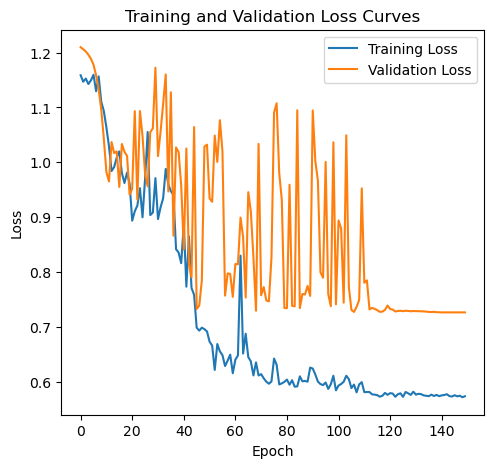

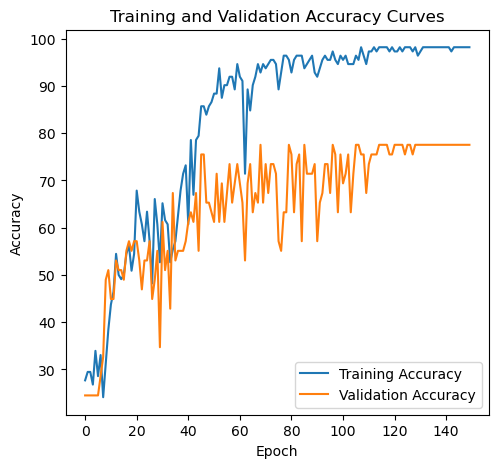

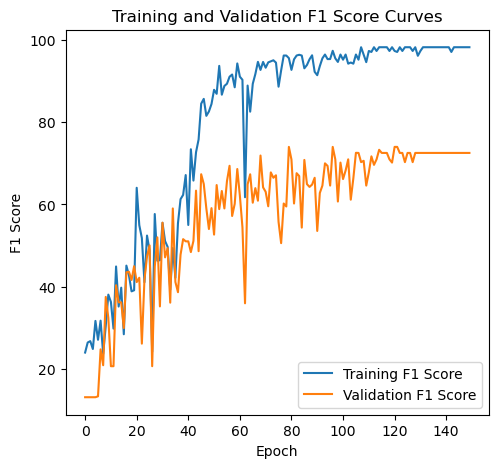

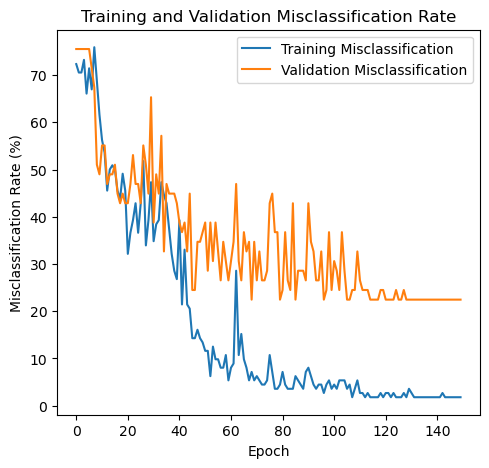

BatchSize:  16  / LR:  0.0001  / WeightDecay:  0.001  / Seed:  42
Best result: Epoch141,        
Train Loss: 0.5754, Train Acc: 98.21%, Train F1: 98.22% |        
Valid Loss: 0.7266, Valid Acc: 77.55%, Valid F1: 72.52%, Valid Misclass: 22.45%


In [20]:
def main():
    seed_everything(config.seed)
    
    # train dataframe
    train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
    
    
    # TODO_4: split the training dataset，通常是 8:2，但可以嘗試其他的分法，e.g. 7:3。
    train_dataset, val_dataset = train_test_split(train_data, train_size=0.7, test_size=0.3, random_state=config.seed)

    

    train_dataset = ParkinsonsDataset(train_dataset, transforms = build_transform(True), mode = "train")
    val_dataset = ParkinsonsDataset(val_dataset, transforms = build_transform(False), mode = "valid")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False)
    

    # settings
    print("Initializing model...")
    
    model = VGGplus(num_classes = config.num_classes, features_grad = True)
    
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model.parameters() if p.requires_grad] 
    
    # TODO_5: 調整適當的 optimizer、scheduler。
    
    optimizer = torch.optim.Adam(parameters, lr = config.lr, weight_decay = config.weight_decay) 
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # recordings
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }
    besteps= 0
    
    
    
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpointFiles/checkpointVGG.pth")
            besteps=epoch
            

        best_ckpt = torch.load("checkpointFiles/checkpointVGG.pth", map_location = config.device, weights_only = False)
        model.load_state_dict(best_ckpt["model"])
    
    printTrainresult(history,besteps)


if __name__ == "__main__":
    main()

## Redefined Resnet


In [21]:
# TODO_7: 用跟 VGG 類似的方式建立 Resnet

class ResNetplus(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), features_grad=False):
        super().__init__()

        # Load the pre-trained ResNet50 model
        resnet50 = models.resnet50(weights='IMAGENET1K_V1', progress=True)

        # Replace the final fully connected layer with nn.Identity() to act as a placeholder
        # This lets us add our own classification layers later.
        resnet50.fc = nn.Identity()

        # Freeze or unfreeze ResNet50 feature layers
        for param in resnet50.parameters():
            param.requires_grad = features_grad
        self.backend = resnet50

        # Add the custom classifier that combines image features with age and gender
        # resnet50 outputs a 2048-dimensional feature vector, and we add age & gender (2 features)
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 2, num_classes)  # 2048: ResNet50 feature vector size, 2: age & gender
        )
        self.softmax = nn.Softmax(dim=1) # 每一個row的總和都是1

    def forward(self, x, age, gender):
        # Pass the input through the ResNet50 backbone
        features = self.backend(x)

        # Concatenate the ResNet output with age and gender features
        combined_features = torch.cat([features, age.view(-1, 1), gender.view(-1, 1)], dim=1)  # Concatenate along the column

        # Pass the combined features through the custom classifier
        outputs = self.classifier(combined_features)
        # if self.out_prob:
        #     outputs = self.softmax(outputs)
        return outputs    
    

Initializing model...
Epoch[1/150], Train Loss: 1.7061, Train Acc: 25.78%, Train F1: 16.74% | Valid Loss: 1.4149, Valid Acc: 27.27%, Valid F1: 14.29%, Valid Misclass: 72.73% | LR: 0.000004
Epoch[2/150], Train Loss: 1.5836, Train Acc: 28.91%, Train F1: 22.30% | Valid Loss: 1.5559, Valid Acc: 30.30%, Valid F1: 15.50%, Valid Misclass: 69.70% | LR: 0.000004
Epoch[3/150], Train Loss: 1.5823, Train Acc: 27.34%, Train F1: 18.57% | Valid Loss: 1.5887, Valid Acc: 30.30%, Valid F1: 15.50%, Valid Misclass: 69.70% | LR: 0.000005
Epoch[4/150], Train Loss: 1.5767, Train Acc: 28.12%, Train F1: 20.05% | Valid Loss: 1.5989, Valid Acc: 30.30%, Valid F1: 15.50%, Valid Misclass: 69.70% | LR: 0.000006
Epoch[5/150], Train Loss: 1.5826, Train Acc: 30.47%, Train F1: 24.71% | Valid Loss: 1.5781, Valid Acc: 30.30%, Valid F1: 15.50%, Valid Misclass: 69.70% | LR: 0.000007
Epoch[6/150], Train Loss: 1.5820, Train Acc: 35.16%, Train F1: 31.07% | Valid Loss: 1.5772, Valid Acc: 30.30%, Valid F1: 15.50%, Valid Misclass

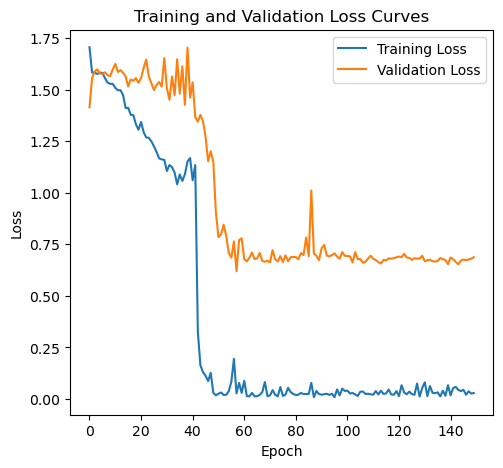

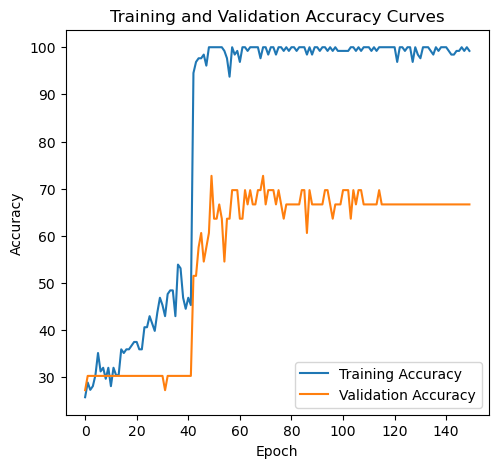

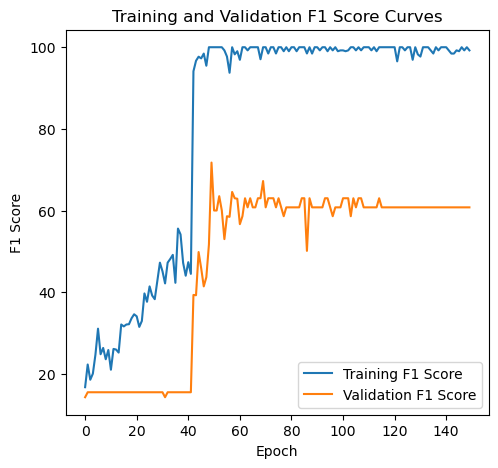

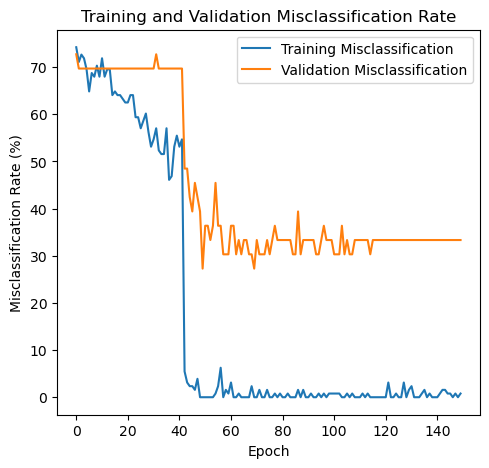

BatchSize:  16  / LR:  0.0001  / WeightDecay:  0.001  / Seed:  42
Best result: Epoch58,        
Train Loss: 0.0273, Train Acc: 100.00%, Train F1: 100.00% |        
Valid Loss: 0.6202, Valid Acc: 69.70%, Valid F1: 64.56%, Valid Misclass: 30.30%


In [22]:
def main():
    seed_everything(config.seed)
    
    # train dataframe
    train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
    
    
    # TODO_4: split the training dataset，通常是 8:2，但可以嘗試其他的分法，e.g. 7:3。
    train_dataset, val_dataset = train_test_split(train_data, train_size=0.8, test_size=0.2, random_state=config.seed)

    train_dataset = ParkinsonsDataset(train_dataset, transforms = build_transform(True), mode = "train")
    val_dataset = ParkinsonsDataset(val_dataset, transforms = build_transform(False), mode = "valid")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False)
    
    # settings
    print("Initializing model...")
    model = ResNetplus(num_classes = config.num_classes, features_grad = True)
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    parameters = [p for p in model.parameters() if p.requires_grad] 
    
    optimizer = torch.optim.Adam(parameters, lr = config.lr, weight_decay = config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }
    besteps= 0
    

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpointFiles/checkpointRes.pth")
            besteps=epoch

        best_ckpt = torch.load("checkpointFiles/checkpointRes.pth", map_location = config.device, weights_only = False)
        model.load_state_dict(best_ckpt["model"])
        
    printTrainresult(history,besteps)

    

if __name__ == "__main__":
    main()

## Redefined VIT

In [23]:
# TODO_7: 建立 VIT(下次助教課會講到)
from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from timm.models.swin_transformer import SwinTransformer, PatchEmbed


class VisionTransformerCustom(nn.Module):
    def __init__(self, num_classes):
        super(VisionTransformerCustom, self).__init__()
        
        self.model = VisionTransformer(
            img_size=56,                # 影像大小
            patch_size=8,               # 一個 patch 大小
            in_chans=1,                 # input channels 大小
            embed_dim=96,               #  patch 經過展平再 linear 的維度
            embed_layer=PatchEmbed,     # 使用 PatchEmbed 完成上述的動作
            norm_layer=nn.LayerNorm,    # 使用 LayerNorm 來 norm
            depth=12,                   # 使用 12個 Blocks(Encoders)
            num_classes=num_classes     # 輸出的維度
        )
        
        self.model.head = nn.Identity() # 將最後的分類弄成 Identity()

        self.classifier = nn.Sequential(
            nn.Linear(96 + 2, num_classes)  # 把 age, gender 放進其中
        )
        

    def forward(self, x, age, gender):
        x = self.model(x)
        x = torch.cat([x, age.view(-1, 1), gender.view(-1, 1)], dim = 1)
        x = self.classifier(x)
        return x

#TODO_1: 設計自己的 SwinTransformer
#參考網站: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/swin_transformer.py

class SwinTransformerCustom(nn.Module):
    def __init__(self, num_classes):
        super(SwinTransformerCustom, self).__init__()

        self.model = SwinTransformer(
            img_size=56,
            patch_size=4,
            in_chans=1,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            mlp_ratio=4.0,
            norm_layer=nn.LayerNorm,
            num_classes=num_classes
        )

        self.model.head.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(768 + 2, num_classes)  # 把 age, gender 放進其中
        )
        

    def forward(self, x, age, gender):
        x = self.model(x)
        x = torch.cat([x, age.view(-1, 1), gender.view(-1, 1)], dim=1)
        x = self.classifier(x)
        return x

c:\Users\mikai\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing Vision Transformer model...


c:\Users\mikai\anaconda3\envs\py38\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


Epoch[1/150], Train Loss: 2.9407, Train Acc: 25.89%, Train F1: 13.71% | Valid Loss: 2.4786, Valid Acc: 30.61%, Valid F1: 15.62%, Valid Misclass: 69.39% | LR: 0.000004
Epoch[2/150], Train Loss: 2.1736, Train Acc: 25.00%, Train F1: 14.31% | Valid Loss: 1.7775, Valid Acc: 32.65%, Valid F1: 20.63%, Valid Misclass: 67.35% | LR: 0.000004
Epoch[3/150], Train Loss: 1.6947, Train Acc: 29.46%, Train F1: 21.83% | Valid Loss: 1.4068, Valid Acc: 40.82%, Valid F1: 30.99%, Valid Misclass: 59.18% | LR: 0.000005
Epoch[4/150], Train Loss: 1.4908, Train Acc: 39.29%, Train F1: 28.61% | Valid Loss: 1.2405, Valid Acc: 46.94%, Valid F1: 32.55%, Valid Misclass: 53.06% | LR: 0.000006
Epoch[5/150], Train Loss: 1.3563, Train Acc: 42.86%, Train F1: 25.61% | Valid Loss: 1.1587, Valid Acc: 46.94%, Valid F1: 32.55%, Valid Misclass: 53.06% | LR: 0.000007
Epoch[6/150], Train Loss: 1.2381, Train Acc: 37.50%, Train F1: 24.82% | Valid Loss: 1.1514, Valid Acc: 44.90%, Valid F1: 32.94%, Valid Misclass: 55.10% | LR: 0.00000

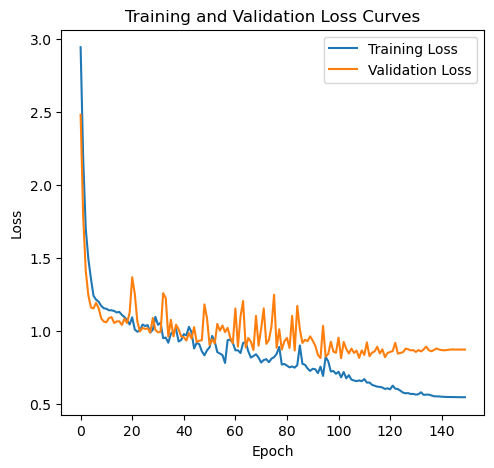

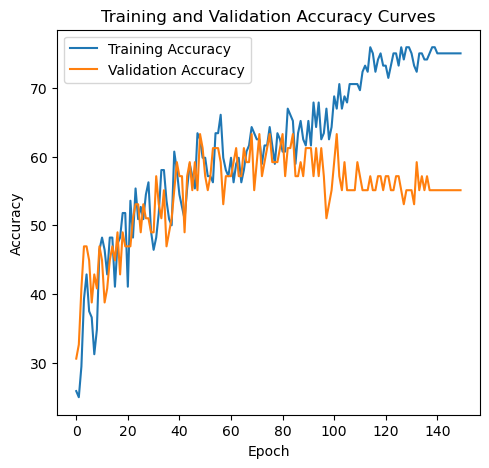

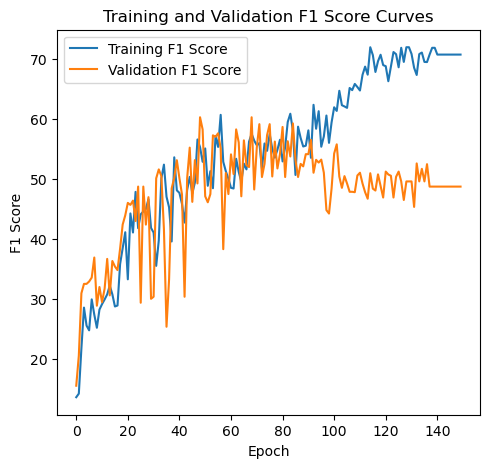

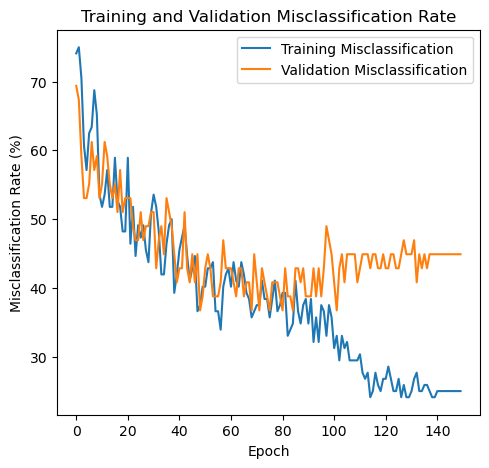

BatchSize:  16  / LR:  0.0001  / WeightDecay:  0.001  / Seed:  42
Best result: Epoch102,        
Train Loss: 0.6793, Train Acc: 66.96%, Train F1: 61.29% |        
Valid Loss: 0.8107, Valid Acc: 63.27%, Valid F1: 55.74%, Valid Misclass: 36.73%


In [24]:
def main():
    # Set seed for reproducibility
    seed_everything(config.seed)
    
    # Load the training data
    train_dataOrg = pd.read_csv(os.path.join(config.root, 'train.csv'))

    # Split the dataset into training and validation sets (70% train, 30% validation)
    train_data, val_data = train_test_split(train_dataOrg, train_size=0.7, test_size=0.3, random_state=config.seed)
    
    # Use the Vision Transformer transformations for ViT model
    train_dataset = ParkinsonsDataset(train_data, transforms=build_transform_ViT(True), mode="train")
    val_dataset = ParkinsonsDataset(val_data, transforms=build_transform_ViT(False), mode="valid")
    
    # DataLoader for training and validation sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    

    # Initialize the Vision Transformer model
    print("Initializing Vision Transformer model...")
    model = VisionTransformerCustom(num_classes=config.num_classes)  # Initialize VisionTransformerCustom

    # Move the model to the appropriate device
    model.to(config.device)

    # Define the loss function (CrossEntropy for classification)
    criterion = nn.CrossEntropyLoss().to(config.device)

    # Optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        epochs=config.epochs,
        steps_per_epoch=len(train_loader),
        max_lr=config.lr,
        anneal_strategy='cos'
    )

    # Metrics tracking best validation loss
    best_val_loss = float("inf")
    history = {
        "train": {"loss": [], "acc": [], "f1": [], "misclass": []},
        "valid": {"loss": [], "acc": [], "f1": [], "misclass": []}
    }
    best_epoch = 0

    # Training loop
    for epoch in range(config.epochs):
        # Train for one epoch
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        
        # Validate after each epoch
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)

        # Record metrics
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        # Print results for each epoch
        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        # Save the best model based on validation loss
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpointFiles/checkpointVit.pth")
            best_epoch = epoch

    # Load the best checkpoint for evaluation
    best_ckpt = torch.load("checkpointFiles/checkpointVit.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])

    # Plot the training and validation results
    printTrainresult(history, best_epoch)

if __name__ == "__main__":
    main()

Initializing Vision Transformer model...
Epoch[1/150], Train Loss: 1.5505, Train Acc: 35.71%, Train F1: 27.48% | Valid Loss: 0.9947, Valid Acc: 44.90%, Valid F1: 20.66%, Valid Misclass: 55.10% | LR: 0.000004
Epoch[2/150], Train Loss: 1.2624, Train Acc: 47.32%, Train F1: 21.41% | Valid Loss: 1.1212, Valid Acc: 44.90%, Valid F1: 30.47%, Valid Misclass: 55.10% | LR: 0.000004
Epoch[3/150], Train Loss: 1.2805, Train Acc: 41.07%, Train F1: 30.52% | Valid Loss: 1.0761, Valid Acc: 36.73%, Valid F1: 25.56%, Valid Misclass: 63.27% | LR: 0.000005
Epoch[4/150], Train Loss: 1.0644, Train Acc: 49.11%, Train F1: 31.33% | Valid Loss: 1.0051, Valid Acc: 44.90%, Valid F1: 20.66%, Valid Misclass: 55.10% | LR: 0.000006
Epoch[5/150], Train Loss: 1.1064, Train Acc: 47.32%, Train F1: 31.19% | Valid Loss: 1.1365, Valid Acc: 46.94%, Valid F1: 35.50%, Valid Misclass: 53.06% | LR: 0.000007
Epoch[6/150], Train Loss: 1.0915, Train Acc: 41.07%, Train F1: 29.90% | Valid Loss: 1.0750, Valid Acc: 44.90%, Valid F1: 32.

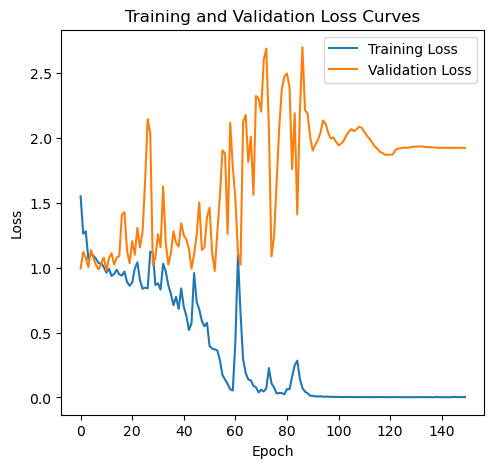

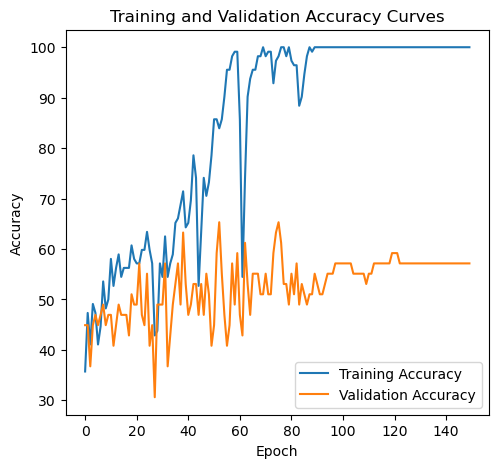

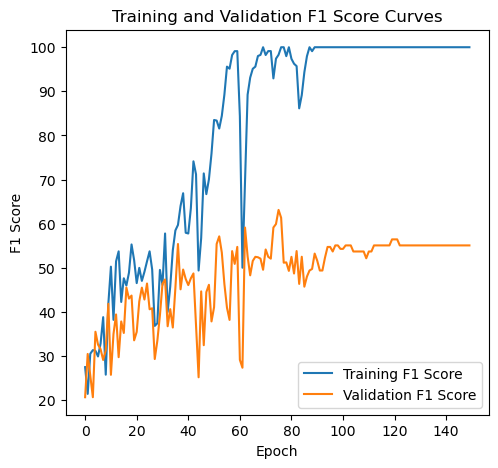

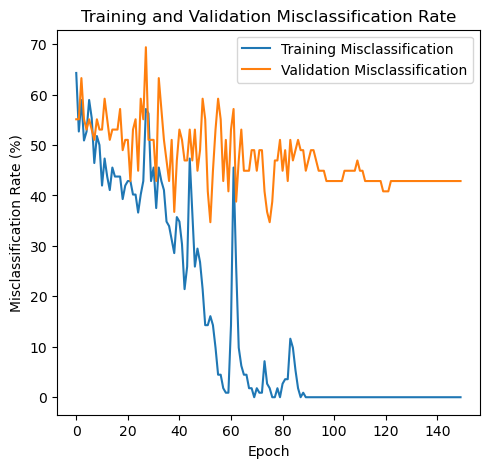

BatchSize:  16  / LR:  0.0001  / WeightDecay:  0.001  / Seed:  42
Best result: Epoch53,        
Train Loss: 0.3709, Train Acc: 83.93%, Train F1: 81.57% |        
Valid Loss: 0.9740, Valid Acc: 65.31%, Valid F1: 57.12%, Valid Misclass: 34.69%


In [25]:
def main():
    # Set seed for reproducibility
    seed_everything(config.seed)
    
    # Load the training data
    train_dataOrg = pd.read_csv(os.path.join(config.root, 'train.csv'))

    # Split the dataset into training and validation sets (70% train, 30% validation)
    train_data, val_data = train_test_split(train_dataOrg, train_size=0.7, test_size=0.3, random_state=config.seed)
            
    # Use the Vision Transformer transformations for ViT model
    train_dataset = ParkinsonsDataset(train_data, transforms=build_transform_ViT(True), mode="train")
    val_dataset = ParkinsonsDataset(val_data, transforms=build_transform_ViT(False), mode="valid")

    # DataLoader for training and validation sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)


    # Model Initialization: Vision Transformer (or SwinTransformer)
    print("Initializing Vision Transformer model...")

    # Initialize the Vision Transformer or SwinTransformer model
    model = SwinTransformerCustom(num_classes=config.num_classes)  # Using SwinTransformerCustom class

    # Move the model to the appropriate device
    model.to(config.device)

    # Define the loss function (CrossEntropy for classification)
    criterion = nn.CrossEntropyLoss().to(config.device)

    # TODO_5: Set the optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    # OneCycleLR learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        epochs=config.epochs,
        steps_per_epoch=len(train_loader),
        max_lr=config.lr,
        anneal_strategy='cos'
    )

    # Initialize metrics for tracking the best validation loss
    best_val_loss = float("inf")
    history = {
        "train": {"loss": [], "acc": [], "f1": [], "misclass": []},
        "valid": {"loss": [], "acc": [], "f1": [], "misclass": []}
    }
    best_epoch = 0

    # Training loop
    for epoch in range(config.epochs):
        # Train for one epoch
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        
        # Validate after each epoch
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)

        # Record metrics
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        # Print results for each epoch
        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        # Save the best model based on validation loss
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpointFiles/checkpointSwin.pth")
            best_epoch = epoch

    # Load the best checkpoint for evaluation
    best_ckpt = torch.load("checkpointFiles/checkpointSwin.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])

    # Plot the training and validation results
    printTrainresult(history, best_epoch)


if __name__ == "__main__":
    main()


## testing

In [26]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad(): 
        for image, age, gender in test_loader:
            image = image.to(device = device, dtype = torch.float)
            age = age.to(device)
            gender = gender.to(device)
            logits = model(image, age, gender)
            pred = torch.argmax(logits, dim = 1)
            preds.append(pred)

    preds = torch.cat(preds)
    
    # TODO_8: 因為輸出的 preds為 0,1,2，所以請調整成 1,2,3。
    preds = preds + 1
    
    return preds
    
seed_everything(config.seed)
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

# TODO_9: 填寫 test_dataset、test_loader、model 四個空格，記得 test_loader 的 shuffle = False。

# Creating the test dataset using the ParkinsonsDataset class
test_dataset1 = ParkinsonsDataset(test_data, mode="test", transforms=build_transform(is_train=False))
# Creating the test dataset using the ParkinsonsDataset class
test_dataset2 = ParkinsonsDataset(test_data, mode="test", transforms=build_transform_ViT(is_train=False))

# DataLoader for the test dataset (shuffle is set to False)
test_loader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=config.batch_size, shuffle=False)
test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=config.batch_size, shuffle=False)

In [27]:
# TODO_10: 將 .csv 取名。

# Initialize the model (VGGplus in this case, could be ResNetplus if you switch)
model = VGGplus(num_classes=config.num_classes, features_grad=True)

best_ckpt = torch.load(f"checkpointFiles/checkpointVGG.pth", map_location=config.device)
model.load_state_dict(best_ckpt["model"])


model.to(config.device)

preds = testing(model, test_loader1, config.device)

# Create a DataFrame with predictions
submission_df = pd.DataFrame()  # Start with an empty DataFrame
submission_df['ID'] = test_data['ID']
# Add the 'Stage' column with predictions
submission_df['Stage'] = preds.cpu().numpy()  # Convert preds from GPU to CPU and then to NumPy

# Specify the path for the submission file
submission_file_path = os.path.join(config.root, 'submissionVGG.csv')  # Ensure this points to the desired directory

# Save the DataFrame to a CSV file
submission_df.to_csv(submission_file_path, index=False, header=True)  # Save without index and with header

print(f"Predictions saved to {submission_file_path}.")  # Print confirmation message


Predictions saved to ./hwk02_data\submissionVGG.csv.


In [28]:
model2 = ResNetplus(num_classes=config.num_classes, features_grad=True)

best_ckpt = torch.load(f"checkpointFiles/checkpointRes.pth", map_location=config.device)
model2.load_state_dict(best_ckpt["model"])

model2.to(config.device)


preds = testing(model2, test_loader1, config.device)
# Create a DataFrame with predictions
submission_df2 = pd.DataFrame()  # Start with an empty DataFrame
submission_df2['ID'] = test_data['ID']

# Add the 'Stage' column with predictions
submission_df2['Stage'] = preds.cpu().numpy()  # Convert preds from GPU to CPU and then to NumPy

# Specify the path for the submission file
submission_file_path2 = os.path.join(config.root, 'submissionRes.csv')  # Ensure this points to the desired directory

# Save the DataFrame to a CSV file
submission_df2.to_csv(submission_file_path2, index=False, header=True)  # Save without index and with header

print(f"Predictions saved to {submission_file_path2}.")  # Print confirmation message


Predictions saved to ./hwk02_data\submissionRes.csv.


In [29]:
model3 = VisionTransformerCustom(num_classes=config.num_classes)

best_ckpt = torch.load(f"checkpointFiles/checkpointVit.pth", map_location=config.device)
model3.load_state_dict(best_ckpt["model"])


model3.to(config.device)

preds = testing(model3, test_loader2, config.device)
# Create a DataFrame with predictions
submission_df3 = pd.DataFrame()  # Start with an empty DataFrame
submission_df3['ID'] = test_data['ID']

# Add the 'Stage' column with predictions
submission_df3['Stage'] = preds.cpu().numpy()  # Convert preds from GPU to CPU and then to NumPy

# Specify the path for the submission file
submission_file_path = os.path.join(config.root, 'submissionVit.csv')  # Ensure this points to the desired directory

# Save the DataFrame to a CSV file
submission_df3.to_csv(submission_file_path, index=False, header=True)  # Save without index and with header

print(f"Predictions saved to {submission_file_path}.")  # Print confirmation message

Predictions saved to ./hwk02_data\submissionVit.csv.


In [30]:
model4 = SwinTransformerCustom(num_classes=config.num_classes)

best_ckpt = torch.load(f"checkpointFiles/checkpointSwin.pth", map_location=config.device)
model4.load_state_dict(best_ckpt["model"])


model4.to(config.device)

preds = testing(model4, test_loader2, config.device)
# Create a DataFrame with predictions
submission_df3 = pd.DataFrame()  # Start with an empty DataFrame
submission_df3['ID'] = test_data['ID']
# Add the 'Stage' column with predictions
submission_df3['Stage'] = preds.cpu().numpy()  # Convert preds from GPU to CPU and then to NumPy

# Specify the path for the submission file
submission_file_path = os.path.join(config.root, 'submissionSwin.csv')  # Ensure this points to the desired directory

# Save the DataFrame to a CSV file
submission_df3.to_csv(submission_file_path, index=False, header=True)  # Save without index and with header

print(f"Predictions saved to {submission_file_path}.")  # Print confirmation message

Predictions saved to ./hwk02_data\submissionSwin.csv.
